In [ ]:
import os
import pandas as pd
import multiprocessing
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
import hashlib
import matplotlib.pyplot as plt


# Data Loading

In [ ]:
SPLITS_ID = 1
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
SEED = 4

In [ ]:
DATASET_PATH = '/kaggle/input/data-car-public/Public'
SPLITS_PATH = '/kaggle/input/cardataset-splits/cardataset_splits'

In [ ]:
train_csv = os.path.join(SPLITS_PATH, f"CarDataset-Splits-{SPLITS_ID}-Train.csv")
test_csv = os.path.join(SPLITS_PATH, f"CarDataset-Splits-{SPLITS_ID}-Test.csv")

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)


train_df["ImageFullPath"] = train_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))
test_df["ImageFullPath"] = test_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))

train_df["CategoryID"] = train_df["CategoryID"].astype(str)
test_df["CategoryID"] = test_df["CategoryID"].astype(str)

In [ ]:
train_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
27858,/kaggle/input/data-car-public/Public/Honda/225...,1
27859,/kaggle/input/data-car-public/Public/Honda/225...,1
27860,/kaggle/input/data-car-public/Public/Honda/225...,1
27861,/kaggle/input/data-car-public/Public/Honda/225...,1


In [ ]:
test_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
6961,/kaggle/input/data-car-public/Public/Honda/225...,1
6962,/kaggle/input/data-car-public/Public/Honda/225...,1
6963,/kaggle/input/data-car-public/Public/Honda/225...,1
6964,/kaggle/input/data-car-public/Public/Honda/225...,1


# Preprocessing

In [ ]:
# Đọc danh sách ảnh trùng lặp
duplicate = pd.read_csv('/kaggle/input/car-duplicateimages/DuplicateImages.csv')
duplicate['Image2'] = duplicate['Image2'].apply(lambda x: os.path.join(DATASET_PATH, x))

# Chỉ lấy những ảnh có Similarity > 0.95
high_similarity_duplicates = duplicate[duplicate['Similarity'] > 0.95]

# Lấy danh sách đường dẫn ảnh cần loại bỏ
duplicate_paths = high_similarity_duplicates['Image2'].unique().tolist()

# Loại bỏ các ảnh trùng lặp khỏi train_df
train_df = train_df[~train_df['ImageFullPath'].isin(duplicate_paths)]

In [ ]:
train_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
27858,/kaggle/input/data-car-public/Public/Honda/225...,1
27859,/kaggle/input/data-car-public/Public/Honda/225...,1
27860,/kaggle/input/data-car-public/Public/Honda/225...,1
27861,/kaggle/input/data-car-public/Public/Honda/225...,1


In [ ]:
def check_image(df, column="ImageFullPath"):
    valid_images = []
    invalid_images = []
    for path in df[column]:
        if not os.path.exists(path):
            print(f"Warning: File not found - {path}")
            continue
        try:
            with Image.open(path) as img:
                img.verify()  # Xác minh file là ảnh hợp lệ
                valid_images.append(path)
        except (UnidentifiedImageError, FileNotFoundError, IOError):
            invalid_images.append(path)
    print(f"Valid images: {len(valid_images)}")
    print(f"Invalid images: {len(invalid_images)}")
    return valid_images

# Kiểm tra dữ liệu train và test
train_valid_paths = check_image(train_df)
test_valid_paths = check_image(test_df)

# Lọc chỉ giữ lại các ảnh hợp lệ
train_df = train_df[train_df['ImageFullPath'].isin(train_valid_paths)]
test_df = test_df[test_df['ImageFullPath'].isin(test_valid_paths)]

Valid images: 26473
Invalid images: 11
Valid images: 6955
Invalid images: 5


In [ ]:
train_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
27858,/kaggle/input/data-car-public/Public/Honda/225...,1
27859,/kaggle/input/data-car-public/Public/Honda/225...,1
27860,/kaggle/input/data-car-public/Public/Honda/225...,1
27861,/kaggle/input/data-car-public/Public/Honda/225...,1


In [ ]:
test_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
6961,/kaggle/input/data-car-public/Public/Honda/225...,1
6962,/kaggle/input/data-car-public/Public/Honda/225...,1
6963,/kaggle/input/data-car-public/Public/Honda/225...,1
6964,/kaggle/input/data-car-public/Public/Honda/225...,1


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Chia dữ liệu theo tỷ lệ lớp
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['CategoryID'],  # Đảm bảo phân phối lớp đồng đều
    random_state=SEED
)

# Khởi tạo ImageDataGenerator
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,          # Xoay ngẫu nhiên
    width_shift_range=0.1,      # Dịch chuyển ngang
    height_shift_range=0.1,     # Dịch chuyển dọc
    shear_range=0.1,            # Biến dạng hình học
    zoom_range=0.2,             # Phóng to / thu nhỏ
    horizontal_flip=True,       # Lật ngang
    fill_mode='nearest'         # Điền các pixel trống bằng giá trị pixel gần nhất
)

test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Cấu hình chung
dataframe_config = {
    'x_col': 'ImageFullPath',
    'y_col': 'CategoryID',
    'target_size': (HEIGHT, WIDTH),
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': SEED,
    'color_mode': 'rgb',
}

# Flow từ DataFrame
train_generator = train_data_generator.flow_from_dataframe(train_data, **dataframe_config)
val_generator = train_data_generator.flow_from_dataframe(val_data, **dataframe_config)
test_generator = test_data_generator.flow_from_dataframe(test_df, **dataframe_config)


Found 21178 validated image filenames belonging to 9 classes.
Found 5295 validated image filenames belonging to 9 classes.
Found 6955 validated image filenames belonging to 9 classes.


In [ ]:
import numpy as np

def check_data_distribution(generator, name):
    # Truy cập các nhãn được gán trong generator
    labels = generator.classes  # Danh sách chỉ số lớp cho mỗi mẫu
    unique, counts = np.unique(labels, return_counts=True)  # Đếm số lượng mẫu mỗi lớp

    # Truy cập tên lớp
    class_names = list(generator.class_indices.keys())  # Danh sách tên các lớp
    distribution = dict(zip(class_names, counts))  # Ghép tên lớp và số lượng mẫu

    print(f"Data Distribution in {name}:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    print("\n")
    return distribution

# Kiểm tra phân phối trên từng generator
train_distribution = check_data_distribution(train_generator, "Train Generator")
val_distribution = check_data_distribution(val_generator, "Validation Generator")
test_distribution = check_data_distribution(test_generator, "Test Generator")


Data Distribution in Train Generator:
  0: 2513
  1: 1841
  2: 2006
  3: 1946
  4: 2036
  5: 1838
  6: 4097
  7: 3577
  8: 1324


Data Distribution in Validation Generator:
  0: 628
  1: 460
  2: 502
  3: 486
  4: 509
  5: 460
  6: 1025
  7: 894
  8: 331


Data Distribution in Test Generator:
  0: 788
  1: 604
  2: 652
  3: 673
  4: 666
  5: 596
  6: 1333
  7: 1184
  8: 459




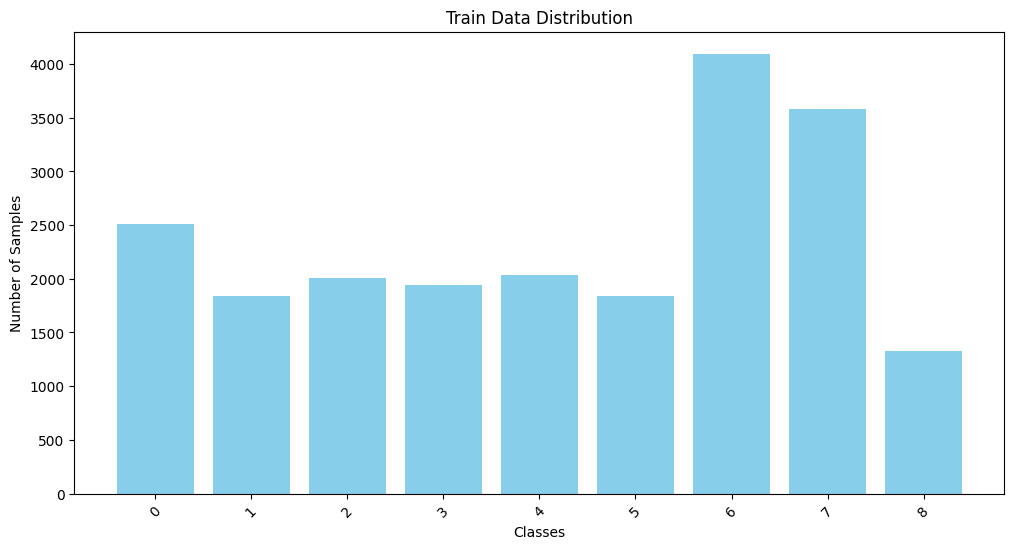

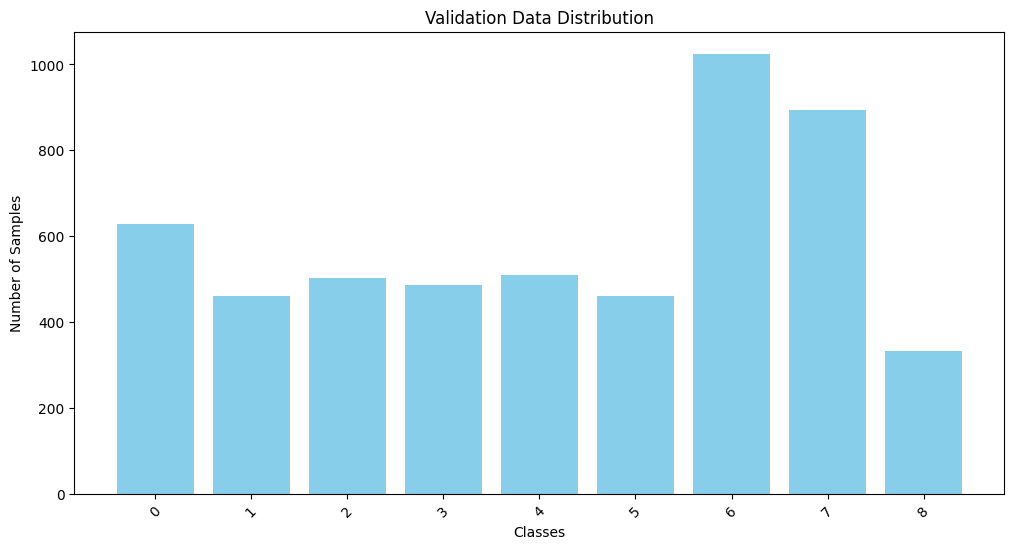

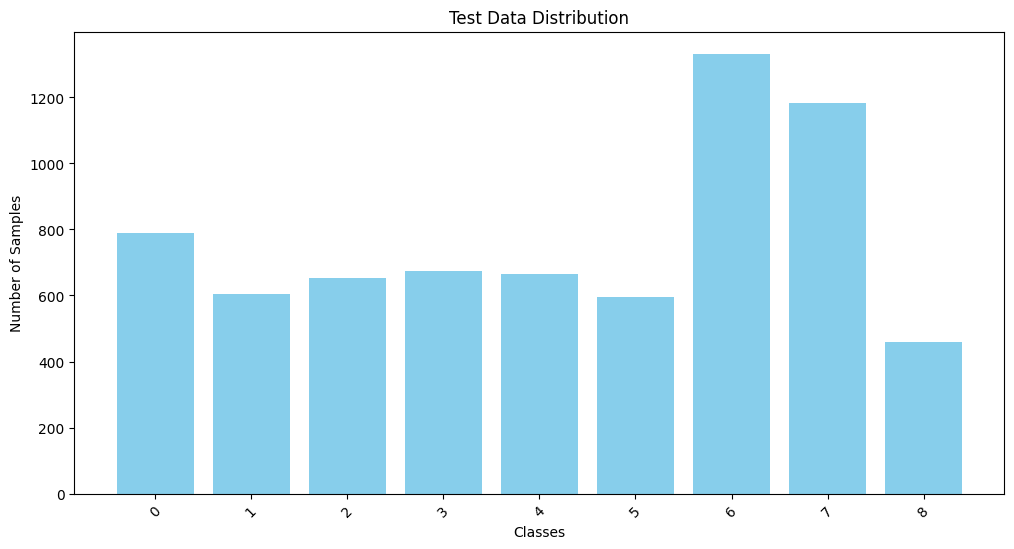

In [ ]:
import matplotlib.pyplot as plt

def plot_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

# Vẽ biểu đồ phân phối
plot_distribution(train_distribution, "Train Data Distribution")
plot_distribution(val_distribution, "Validation Data Distribution")
plot_distribution(test_distribution, "Test Data Distribution")


In [ ]:
base_model = ResNet50(
    include_top=False,  
    weights='imagenet', 
    input_shape=(224, 224, 3) 
)

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))  

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler

# Callbacks
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, verbose=1)

callbacks = [checkpoint]

In [ ]:
learning_rate = 0.0001
epochs = 30

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/331 ━━━━━━━━━━━━━━━━━━━━ 4:55 905ms/step - accuracy: 0.0560 - loss: 2.3328

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2688 - loss: 1.9794
Epoch 1: val_loss improved from inf to 1.39236, saving model to model.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 603s 2s/step - accuracy: 0.2691 - loss: 1.9788 - val_accuracy: 0.5195 - val_loss: 1.3924
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5507 - loss: 1.3032
Epoch 2: val_loss improved from 1.39236 to 1.07000, saving model to model.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.5508 - loss: 1.3030 - val_accuracy: 0.6393 - val_loss: 1.0700
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6893 - loss: 0.9178
Epoch 3: val_loss improved from 1.07000 to 0.88824, saving model to model.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.6893 - loss: 0.9177 - val_accuracy: 0.7063 - val_loss: 0.8882
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7554 - loss: 0.7234
Epoch 4: val_loss improved from 0.88824 to 0.87984, saving model to model.keras
3

# Testing

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {accuracy}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 101s 930ms/step - accuracy: 0.8219 - loss: 0.7688
Test Accuracy: 0.8196980357170105


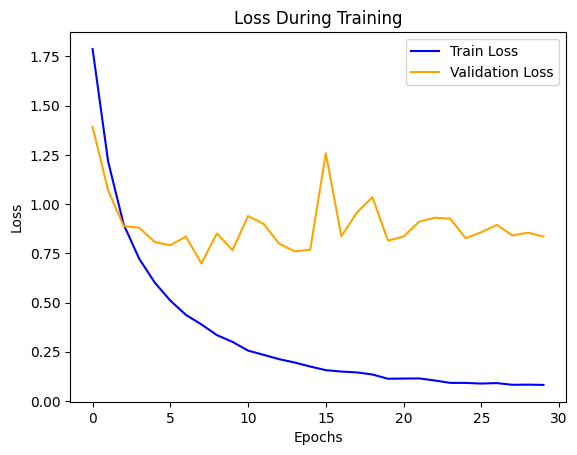

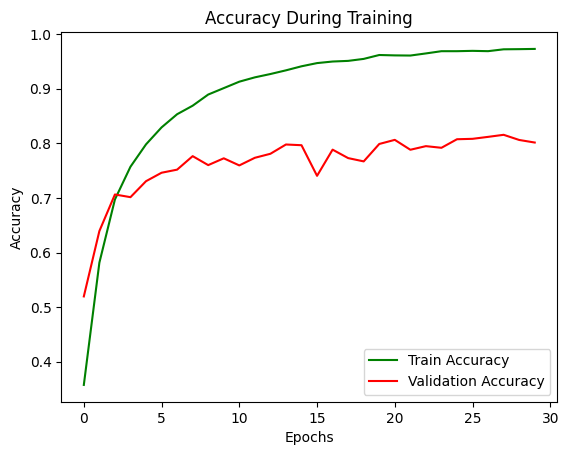

In [ ]:
import matplotlib.pyplot as plt

# Lấy giá trị loss và accuracy từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ biểu đồ loss
# plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ accuracy
# plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()